In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanAbsolutePercentageError as MAPE
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
import Dataset_Class as DC



# USE_CUDA = torch.cuda.is_available()
# DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE = 'cpu'
RANDOM_SEED = 2023

In [2]:
pv_features = pd.read_csv("./processed_data/pv/pv_forecast_features.csv")
pv_features = pv_features.drop(columns = ['Unnamed: 0'])
pv_features_length = len(pv_features)
X = pv_features.iloc[0:pv_features_length-24][['SL', 'SR', 'HM', 'PV']]
Y = pv_features.iloc[24:pv_features_length][['PV']].copy().reset_index(drop=True)   # X and Y should be divided completely, so Y get deeply copied.

In [3]:
# correlation between features of X and Y
X.corrwith(Y.PV)

SL    0.566595
SR    0.756936
HM   -0.311709
PV    0.763057
dtype: float64

In [4]:
def plotYear(data, ylabel):
    label_interval = [18, 17, 22, 21, 19, 15, 22, 21, 21, 19, 21, 18]

    data = data

    # Create figure and plot the data
    fig = plt.figure(figsize=(10,2.5))
    ax = plt.axes()
    ax.plot(data)

    plt.title('Original Data X')
    plt.xlabel('Month', fontsize = 10)
    plt.ylabel(ylabel, fontsize = 10)

    # Set the x-tick positions and labels
    x_ticks = []
    x_labels = []
    for i, interval in enumerate(label_interval):
        # start = sum(label_interval[:i])*24
        start = sum(label_interval[:i])
        x_ticks.append(start)
        x_labels.append(f'{i+1}')

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)


In [5]:
def selColToPlot(col_name):
    sl_df = X[[col_name]]
    sl_tnsr = torch.FloatTensor(sl_df.values)
    sum_per_day = []
    s = 0.0
    cnt = 0
    for e in sl_tnsr:
        s += float(e)
        cnt+=1
        if cnt%24==0:
            sum_per_day.append(s)
            cnt = 0
            s = 0
    return sum_per_day

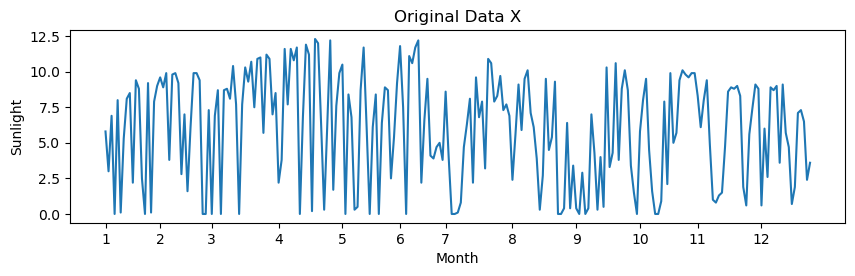

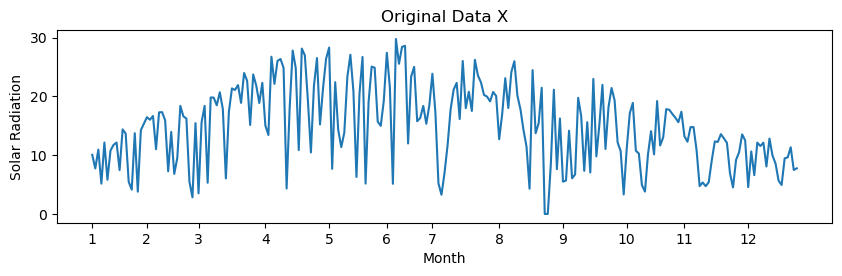

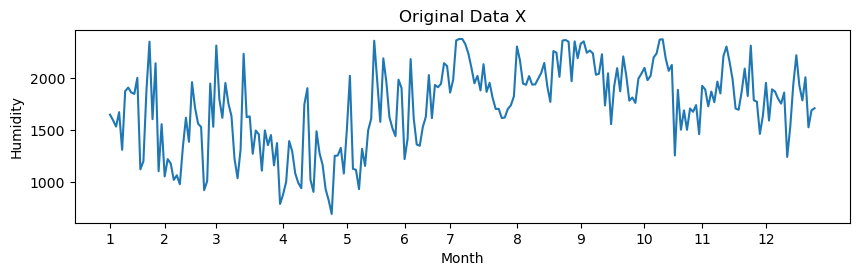

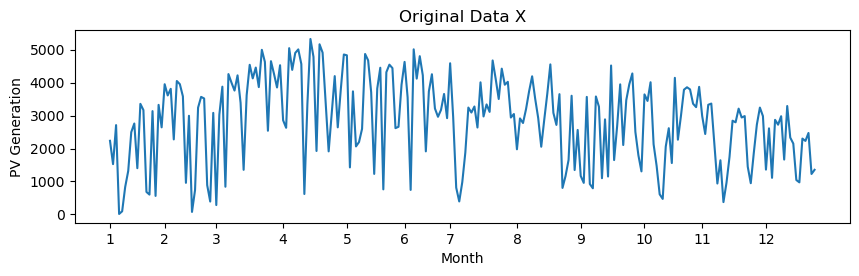

In [6]:
plotYear(selColToPlot('SL'), 'Sunlight')
plotYear(selColToPlot('SR'), 'Solar Radiation')
plotYear(selColToPlot('HM'), 'Humidity')
plotYear(selColToPlot('PV'), 'PV Generation')

In [7]:
X = torch.FloatTensor(X.values)
Y = torch.FloatTensor(Y.values)

In [8]:
dataset = DC.CustomDataset(X, Y)
data_len = dataset.__len__()

In [9]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)



# load forecast model에서 사용한 dataset 기간과 동일하게 설정
train_size = 186*24
mini_train_size = 148*24

train_data = DC.CustomDataset(X[:train_size], Y[:train_size])                                 # 186*24개   210104 ~ 211015
test_data = DC.CustomDataset(X[train_size:], Y[train_size:])                                  # 47*24개    211018 ~ 211229
mini_train_data = DC.CustomDataset(X[:mini_train_size], Y[:mini_train_size])                  # 148*24개   210104 ~ 210819
valid_data = DC.CustomDataset(X[mini_train_size:train_size], Y[mini_train_size:train_size])   # 38*24개    210820 ~ 211015

mini_train_dataloader = DataLoader(mini_train_data, batch_size = 1024, shuffle = True)
valid_dataloader = DataLoader(valid_data, batch_size = valid_data.__len__(), shuffle = False)
train_dataloader = DataLoader(train_data, batch_size = 1024, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = test_data.__len__(), shuffle = False)

In [10]:
# same as model.ipynb
def train(model, trian_dataloader, optimizer, criterion):
    model.train()
    loss_sum = 0.0
    for (x, y) in train_dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        output = model(x)
        train_loss = criterion(output, y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        loss_sum += train_loss
    
    return (loss_sum/len(trian_dataloader.dataset)).item() # loss of each epoch


def evaluate(model, valid_dataloader):
    model.eval()
    with torch.no_grad():
        for (x, y) in valid_dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
                
            output = model(x)
            
        return output, y

In [11]:
X.shape

torch.Size([5592, 4])

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 1024)
        # self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(1024, 1)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.batch_norm2 = nn.BatchNorm1d(1024)
        # self.sig = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        # x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = self.batch_norm2(x)
        x = self.relu(x)
        # x = self.fc3(x)
        # x = self.relu(x)
        output = self.fc4(x)
        return output

In [15]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


model = Net().to(DEVICE)

EPOCHS = 1000
LEARNING_RATE = 0.0001
# MOMENTUM = 0.9

# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.MSELoss()
mini_train_loss_arr = []
val_loss_arr = []


# model training and validation
best_val_loss = float('inf')
best_val_epoch = 0


for epoch in range(EPOCHS):
    mini_train_loss = train(model, mini_train_dataloader, optimizer, criterion)
    mini_train_loss_arr.append(mini_train_loss)
    val_output, val_y = evaluate(model, valid_dataloader)
    val_loss = criterion(val_output, val_y)
    val_loss_arr.append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_epoch = epoch
        # torch.save(model.state_dict(), './model.pt')
        # print('state_dict format of the model:\n{}'.format(model.state_dict()))
    if epoch % 200 == 0:
        print('Train Epoch: {:4d}/{}  |  Train Loss {:.6f}  |  Val Loss {:.6f}'.format(
            epoch, EPOCHS, mini_train_loss, val_loss))


print('-'*80)
print('The Best Epoch: {}  |  The Best Validation Error: {:.6f}'.format(
    best_val_epoch, best_val_loss
))

Train Epoch:    0/1000  |  Train Loss 70.864151  |  Val Loss 30288.605469
Train Epoch:  200/1000  |  Train Loss 19.406181  |  Val Loss 13979.049805
Train Epoch:  400/1000  |  Train Loss 19.487677  |  Val Loss 14412.965820
Train Epoch:  600/1000  |  Train Loss 19.481695  |  Val Loss 13922.127930
Train Epoch:  800/1000  |  Train Loss 19.906752  |  Val Loss 13880.544922
--------------------------------------------------------------------------------
The Best Epoch: 683  |  The Best Validation Error: 13525.624023


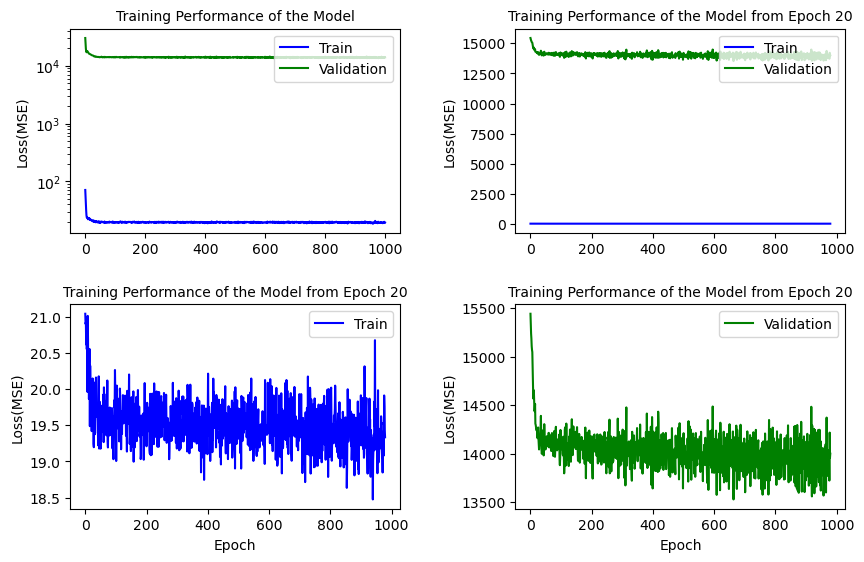

In [16]:
fig = plt.figure(figsize=(10,6))

FONT_SIZE = 10

plt.subplot(221)
plt.title('Training Performance of the Model', fontsize = FONT_SIZE)
# plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
plt.yscale('log')
plt.plot(mini_train_loss_arr[0:], c = 'blue', label = 'Train')
plt.plot(val_loss_arr[0:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(222)
plt.title('Training Performance of the Model from Epoch 20', fontsize = FONT_SIZE)
# plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[20:], c = 'blue', label = 'Train')
plt.plot(val_loss_arr[20:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(223)
plt.title('Training Performance of the Model from Epoch 20', fontsize = FONT_SIZE)
plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[20:], c = 'blue', label = 'Train')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(224)
plt.title('Training Performance of the Model from Epoch 20', fontsize = FONT_SIZE)
plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(val_loss_arr[20:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)

In [17]:
torch.save(model.state_dict(), './model_pt/pv_model_1024.pt')

In [18]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


mae = nn.L1Loss()
mape = MAPE()


for epoch in range(best_val_epoch):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    if epoch % 200 == 0:
        print('Train Epoch: {:4d}/{}  |  Train Loss {:.6f}'.format(
            epoch, best_val_epoch, train_loss))

Train Epoch:    0/683  |  Train Loss 15.431016
Train Epoch:  200/683  |  Train Loss 15.223748
Train Epoch:  400/683  |  Train Loss 15.270734
Train Epoch:  600/683  |  Train Loss 15.256080


In [ ]:
train_data.__len__()/24

186.0

In [19]:
test_output, test_y = evaluate(model, test_dataloader)

test_mse = criterion(test_output, test_y)
test_mae = mae(test_output, test_y)
# test_mape = mape(test_output, test_y)


print('Test Loss')
print('MSE: {:.6f}'.format(test_mse))
print('MAE: {:.6f}'.format(test_mae))
# print('MAPE(%): {:.6f}'.format(test_mape*100))  # 실제 정답값에 0이 포함되기 때문에 계산 불가능

Test Loss
MSE: 8187.356445
MAE: 48.196213


In [20]:
def plot(i, length, output, Y):
    fig = plt.figure(figsize=(20, 5))
    ax = plt.axes()
    plt.title('Actual and forecast PV generation for 20 days', fontsize = 18)
    plt.xlabel('Time (h)', fontsize = 15)
    plt.ylabel('Net-load', fontsize = 15)
    x_ticks = range(0,length*24, 24)
    x_labels = range(0, length)
    ax.set_xticks(x_ticks, x_labels)
    plt.plot(Y.detach().numpy()[i:i+(length*24),:].reshape(-1), c='blue', label = 'Actual data')
    plt.plot(output.detach().numpy()[i:i+(length*24),:].reshape(-1), c='red', label = 'forecast data')
    plt.legend(loc='lower right', fontsize = 13)


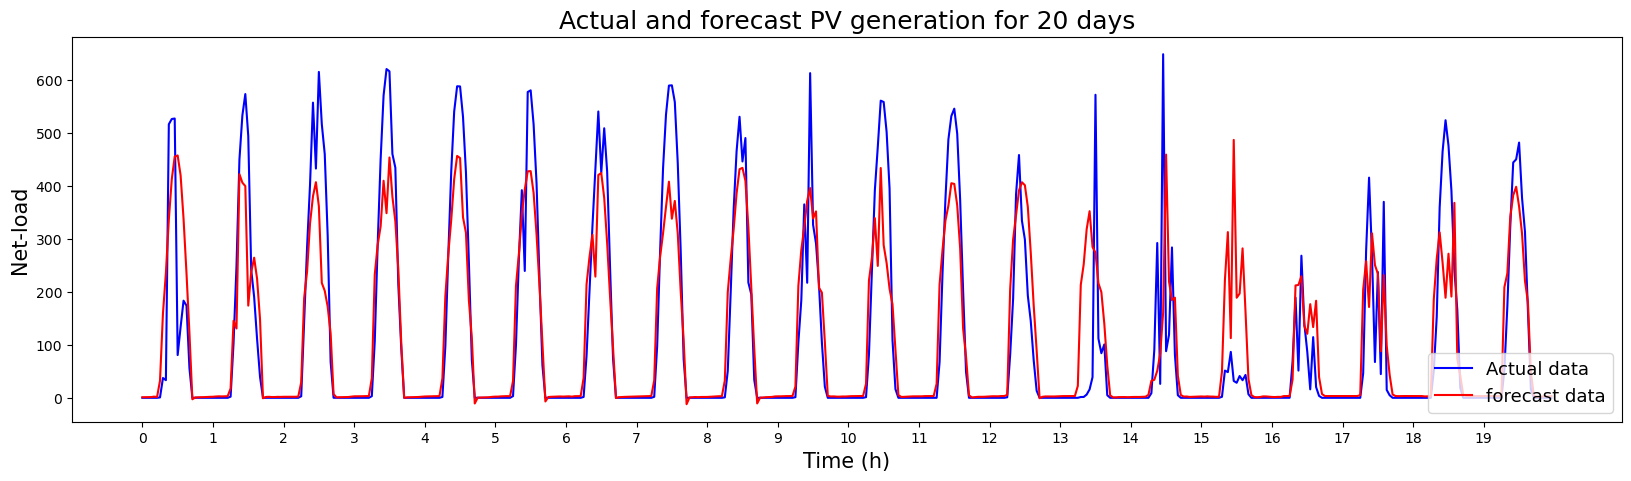

In [21]:
# 211020 ~ 211117
plot(1, 20, test_output, test_y)